Circuit Diagram:
---------------


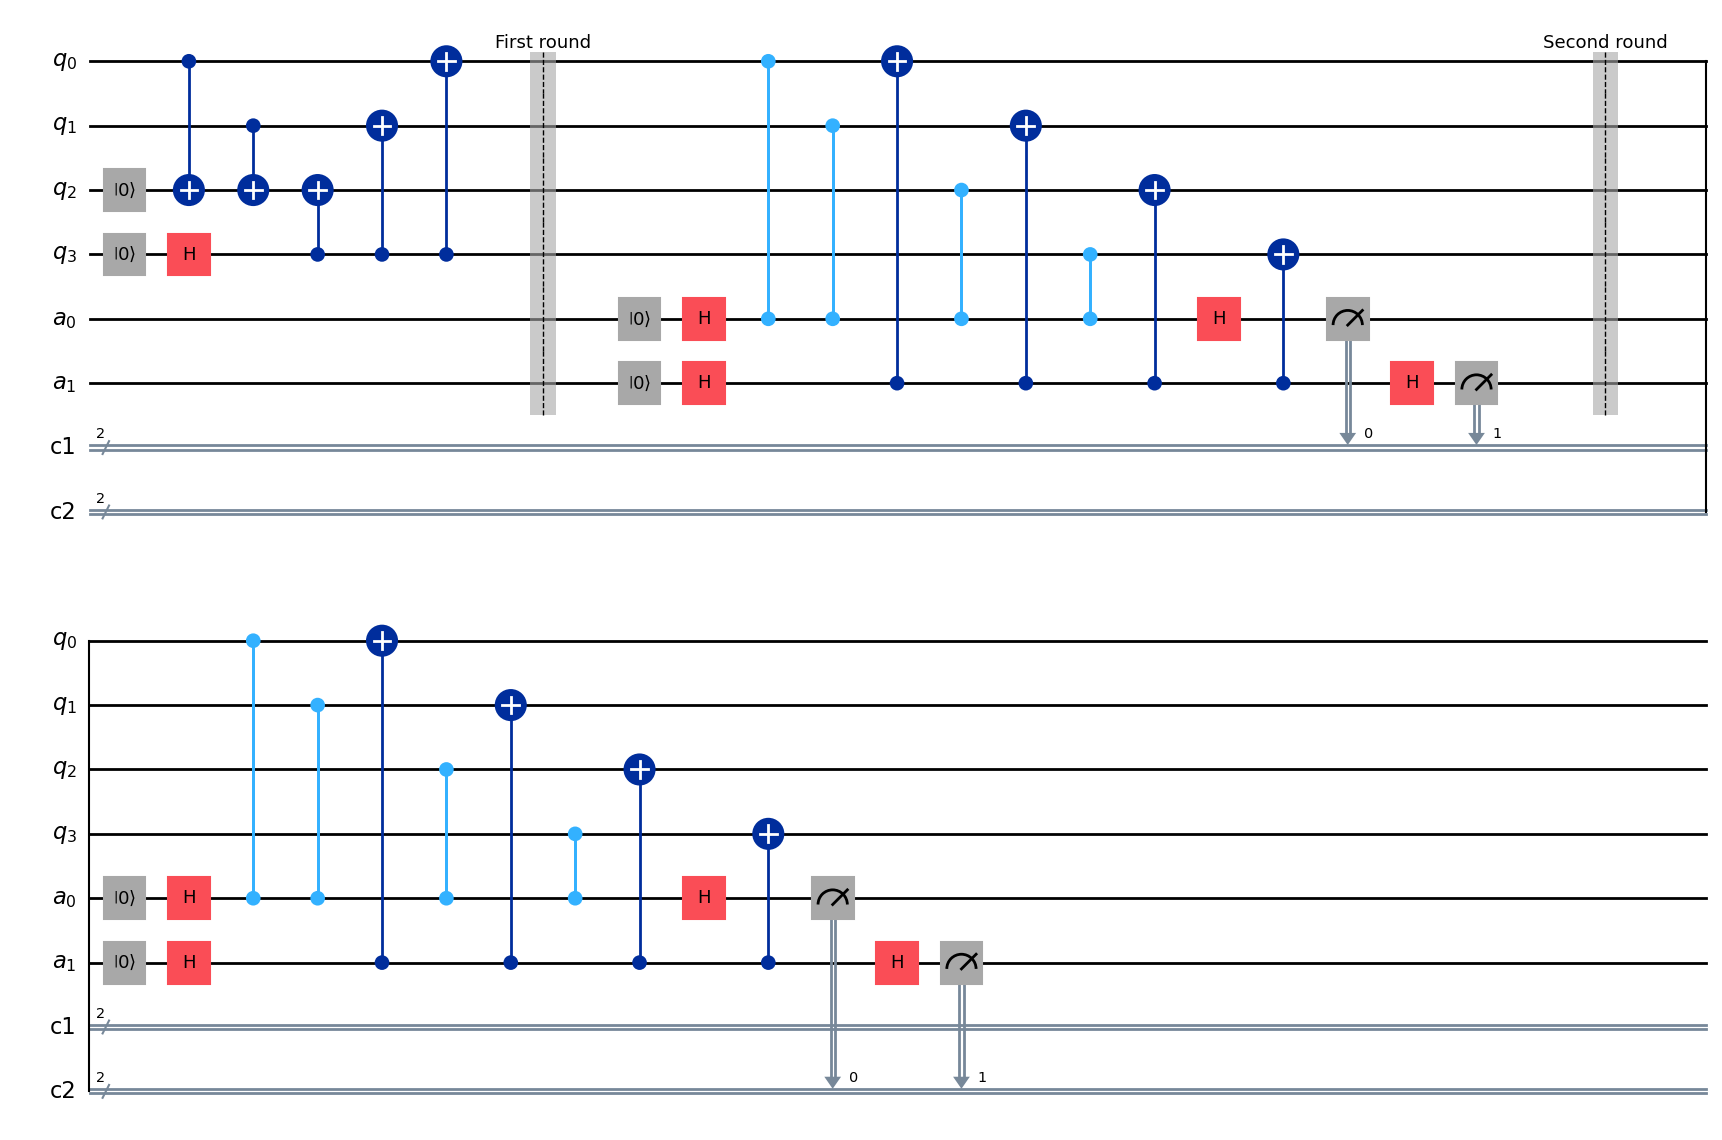

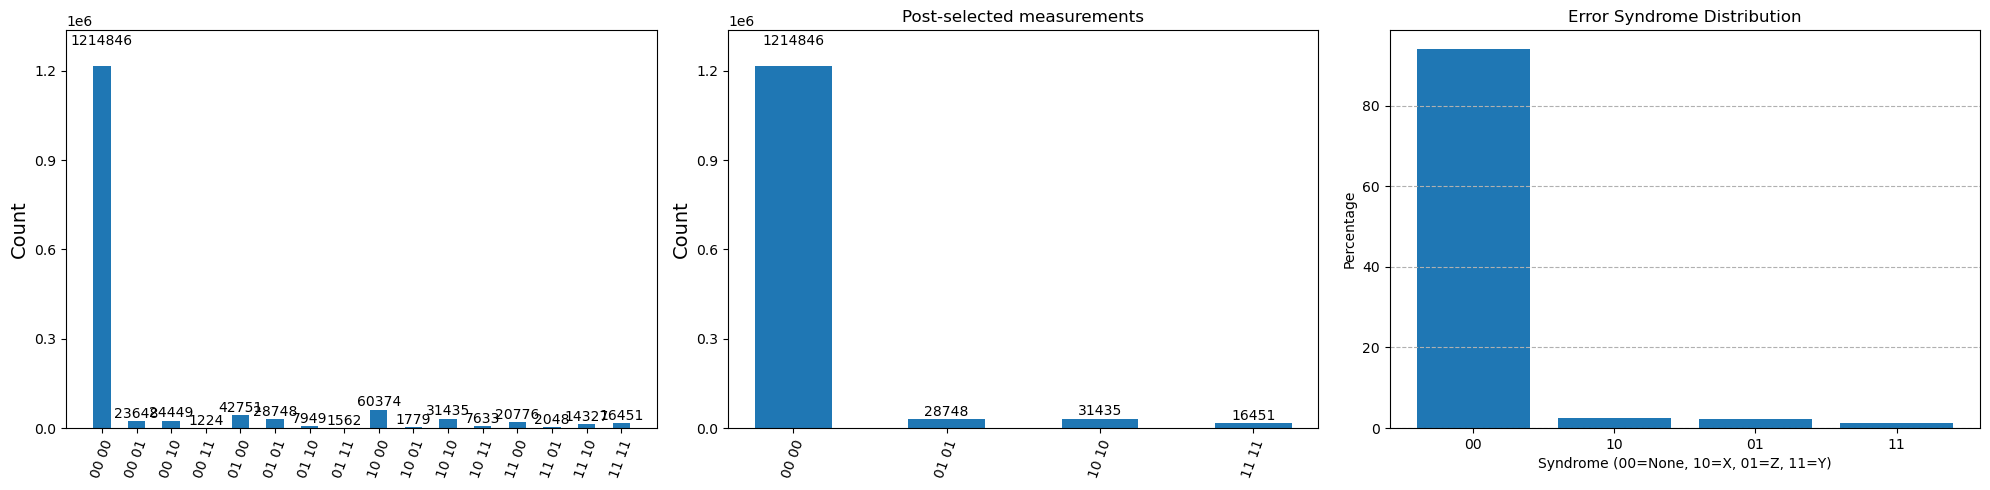


Error Analysis:
---------------
Error Types (counts): {'00': 1214846, '10': 31435, '01': 28748, '11': 16451}
Error Percentages: {'00': '94.07%', '10': '2.43%', '01': '2.23%', '11': '1.27%'}

Circuit Analysis:
---------------
Total shots: 1500000
Valid shots: 1291480
Post-selection ratio: 0.8609866666666667


In [1]:
"""
Quantum Error Correction Circuit Implementation and Simulation

This implementation includes:
- Two rounds of syndrome extraction for error detection
- Proper depolarising noise model based on space radiation effects
- Error analysis and visualisation
- Post-selection of valid measurements

Author: Quantarverse Ltd
"""

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_gate_map
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error
import matplotlib.pyplot as plt

class QECCircuit:
    def __init__(self, error_probability=0.01):
        """
        Initialize QEC circuit with given error probability.
        
        Args:
            error_probability (float): Probability of error per gate (default: 0.01)
        """
        self.error_probability = error_probability
        self.noise_model = self._create_noise_model()
        self.circuit = self._create_circuit()
        
    def _create_noise_model(self):
        """
        Create a realistic noise model with depolarizing errors.
        
        Returns:
            NoiseModel: Qiskit noise model with appropriate error rates
        """
        noise_model = NoiseModel()
        
        # Single-qubit depolarizing error
        p = self.error_probability / 3
        single_qubit_depol = pauli_error([
            ('X', p), ('Y', p), ('Z', p), ('I', 1 - 3*p)
        ])
        
        # Two-qubit depolarizing error
        cnot_error = depolarizing_error(self.error_probability, 2)
        
        # Add errors for all gates
        for qubit in range(6):  # 4 data + 2 ancilla qubits
            noise_model.add_quantum_error(single_qubit_depol, ['x'], [qubit])
            noise_model.add_quantum_error(single_qubit_depol, ['h'], [qubit])
            noise_model.add_quantum_error(single_qubit_depol, ['z'], [qubit])
        
        for q1 in range(6):
            for q2 in range(6):
                if q1 != q2:
                    noise_model.add_quantum_error(cnot_error, ['cx'], [q1, q2])
                    noise_model.add_quantum_error(cnot_error, ['cz'], [q1, q2])
                    
        return noise_model
    
    def _create_circuit(self):
        """
        Create the quantum circuit with two rounds of syndrome extraction.
        
        Returns:
            QuantumCircuit: Complete QEC circuit
        """
        # Create registers
        data_qubits = QuantumRegister(4, 'q')
        ancilla_qubits = QuantumRegister(2, 'a')
        c1 = ClassicalRegister(2, 'c1')  # First round measurements
        c2 = ClassicalRegister(2, 'c2')  # Second round measurements
        
        qc = QuantumCircuit(data_qubits, ancilla_qubits, c1, c2)
        
        # Initialize data qubits
        qc.reset(data_qubits[2])
        qc.reset(data_qubits[3])
        qc.h(data_qubits[3])
        
        # Entangle logical qubits
        qc.cx(data_qubits[0], data_qubits[2])
        qc.cx(data_qubits[1], data_qubits[2])
        qc.cx(data_qubits[3], data_qubits[2])
        qc.cx(data_qubits[3], data_qubits[1])
        qc.cx(data_qubits[3], data_qubits[0])
        
        # First round of syndrome extraction
        qc.barrier(label='First round')
        self._add_syndrome_measurement(qc, data_qubits, ancilla_qubits, c1)
        
        # Second round of syndrome extraction
        qc.barrier(label='Second round')
        self._add_syndrome_measurement(qc, data_qubits, ancilla_qubits, c2)
        
        return qc
    
    def _add_syndrome_measurement(self, qc, data_qubits, ancilla_qubits, creg):
        """
        Add syndrome measurement round to the circuit.
        
        Args:
            qc (QuantumCircuit): Circuit to add measurements to
            data_qubits (QuantumRegister): Data qubit register
            ancilla_qubits (QuantumRegister): Ancilla qubit register
            creg (ClassicalRegister): Classical register for measurements
        """
        # Z syndrome
        qc.reset(ancilla_qubits[0])
        qc.h(ancilla_qubits[0])
        for i in range(4):
            qc.cz(ancilla_qubits[0], data_qubits[i])
        qc.h(ancilla_qubits[0])
        qc.measure(ancilla_qubits[0], creg[0])
        
        # X syndrome
        qc.reset(ancilla_qubits[1])
        qc.h(ancilla_qubits[1])
        for i in range(4):
            qc.cx(ancilla_qubits[1], data_qubits[i])
        qc.h(ancilla_qubits[1])
        qc.measure(ancilla_qubits[1], creg[1])
    
    def run_circuit(self, shots=10000):
        # Run simulation
        simulator = AerSimulator(noise_model=self.noise_model)
        result = simulator.run(self.circuit, shots=shots).result()
        counts = result.get_counts()
        
        # Post-select valid results
        valid_shots = {k: v for k, v in counts.items() 
                      if k[-2:] == k[:2]}  # Compare first and second rounds
        
        # Analyze error types
        error_types = {'00': 0, '10': 0, '01': 0, '11': 0}
        total_valid = sum(valid_shots.values()) if valid_shots else 0
        
        for bitstring, count in valid_shots.items():
            syndrome = bitstring[-2:]
            if syndrome in error_types:
                error_types[syndrome] += count
        
        # Calculate percentages
        error_percentages = {
            syndrome: (count/total_valid*100 if total_valid > 0 else 0.0)
            for syndrome, count in error_types.items()
        }
        
        return {
            'counts': counts,
            'valid_shots': valid_shots,
            'error_types': error_types,
            'error_percentages': error_percentages,
            'total_shots': shots,
            'valid_shot_count': total_valid,
            'post_selection_ratio': total_valid/shots if shots > 0 else 0
        }
    
    def visualize_results(self, results):
        # First create the circuit diagram
        print("Circuit Diagram:")
        print("---------------")
        display(self.circuit.draw(output='mpl', style={'backgroundcolor': '#FFFFFF'}))
        
        # Create figure for results visualization
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
        
        # All measurements
        plot_histogram(results['counts'], title="All measurements", ax=ax1)
        
        # Post-selected measurements
        if results['valid_shots']:
            plot_histogram(results['valid_shots'], 
                         title="Post-selected measurements", ax=ax2)
        else:
            ax2.text(0.5, 0.5, "No valid post-selected measurements",
                    horizontalalignment='center', verticalalignment='center')
        ax2.set_title("Post-selected measurements")
        
        # Error distribution
        syndromes = list(results['error_types'].keys())
        percentages = [results['error_percentages'][s] for s in syndromes]
        ax3.bar(syndromes, percentages)
        ax3.set_title("Error Syndrome Distribution")
        ax3.set_ylabel("Percentage")
        ax3.set_xlabel("Syndrome (00=None, 10=X, 01=Z, 11=Y)")
        ax3.set_ylim(bottom=0)
        
        plt.tight_layout()
        plt.show()
        
        # Print analysis
        print("\nError Analysis:")
        print("---------------")
        print("Error Types (counts):", results['error_types'])
        print("Error Percentages:", {k: f"{v:.2f}%" 
                                   for k, v in results['error_percentages'].items()})
        print("\nCircuit Analysis:")
        print("---------------")
        print("Total shots:", results['total_shots'])
        print("Valid shots:", results['valid_shot_count'])
        print("Post-selection ratio:", results['post_selection_ratio'])

def main():
    """Main execution function."""
    # Create and run circuit
    qec = QECCircuit(error_probability=0.01)
    results = qec.run_circuit(shots=1500000)
    qec.visualize_results(results)

if __name__ == "__main__":
    main()